In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn import metrics
from scipy import stats
from sklearn import neighbors
from sklearn import datasets
from sklearn import metrics
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import pairwise_distances
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from pprint import pprint
import operator

from tpknnsource import (rand_gauss, rand_bi_gauss, rand_tri_gauss,
                         rand_checkers, rand_clown, plot_2d, ErrorCurve,
                         frontiere_new, LOOCurve)


import seaborn as sns
from matplotlib import rc

%matplotlib notebook

plt.close('all')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': False,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("white")
sns.axes_style()
pass

#     Data Generation: example

In [2]:
np.random.seed(42)  # fix seed globally

n = 100
mu = [1., 1.]
sigma = [1., 1.]
rand_gauss(n, mu, sigma)

n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

n1 = 50
n2 = 50
n3 = 50
mu1 = [1., 1.]
mu2 = [-1., -1.]
mu3 = [1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
sigma3 = [0.9, 0.9]
X2, y2 = rand_tri_gauss(n1, n2, n3, mu1, mu2, mu3, sigma1, sigma2, sigma3)

n1 = 50
n2 = 50
sigma1 = 1.
sigma2 = 5.
X3, y3 = rand_clown(n1, n2, sigma1, sigma2)

n1 = 150
n2 = 150
sigma = 0.1
X4, y4 = rand_checkers(n1, n2, sigma)

#     Displaying labeled data

In [3]:
# plt.show()
# plt.close("all")
# plt.ion()
# plt.figure(1, figsize=(10,8))
# plt.subplot(111)
# plt.title('First data set')
# plot_2d(X1, y1)

# plt.figure(2, figsize=(10,8))
# plt.subplot(111)
# plt.title('Second data set')
# plot_2d(X2, y2)

# plt.figure(3, figsize=(10,8))
# plt.subplot(111)
# plt.title('Third data set')
# plot_2d(X3, y3)

# plt.figure(4, figsize=(10,8))
# plt.subplot(111)
# plt.title('Fourth data set')
# plot_2d(X4, y4)

#     K-NN

In [22]:
class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=1, weight='uniform'):
        self.n_neighbors = n_neighbors
        self.weights = weight if weight is not 'uniform' else lambda x: 1

    def fit(self, X, y):
        self.X_ = X
        self.y_ = y
        return self

    def predict(self, X):
        dist = pairwise_distances(X, self.X_)
        closest = [arr[:self.n_neighbors] for arr in np.argsort(dist)]
        
        return [max_arg_dict({l: self.label_weight(l, p, dist[i]) 
                    for l in set([self.y_[i] for i in p])}) 
                for i, p in enumerate(closest)]
        
    def label_weight(self, label, p, dist):
        idx = [k for k in p if self.y_[k] == label]
        return np.sum([self.weights(dist[d]) for d in idx])
    
def max_arg_dict(d):
    return max(d.items(), key=operator.itemgetter(1))[0]

def compare_acc(X, y, k=5, w=None):
    X_tr = X[::2]
    Y_tr = y[::2].astype(int)
    X_te = X[1::2]
    Y_te = y[1::2].astype(int)
    compute_acc(KNNClassifier, X_tr, Y_tr, X_te, Y_te, k, w)
    compute_acc(KNeighborsClassifier, X_tr, Y_tr, X_te, Y_te, k)

def compute_acc(model, X_tr, Y_tr, X_te, Y_te, k, w='uniform'):
    clf = model(k, w).fit(X_tr, Y_tr)
    acc = np.sum(clf.predict(X_te) == Y_te) / len(Y_te)
    print("Accuracy", type(clf).__name__, ':', acc)

def weight(d, h=500):
    return np.exp(-d**2 / h)

for k in [1, 3, 5, 20, 50]:
    print("k = ", k)
    compare_acc(X2, y2, k, weight)
    compare_acc(X3, y3, k, weight)
    compare_acc(X4, y4, k, weight)
    print()

k =  1
Accuracy KNNClassifier : 0.746666666667
Accuracy KNeighborsClassifier : 0.746666666667
Accuracy KNNClassifier : 0.72
Accuracy KNeighborsClassifier : 0.72
Accuracy KNNClassifier : 0.868055555556
Accuracy KNeighborsClassifier : 0.868055555556

k =  3
Accuracy KNNClassifier : 0.746666666667
Accuracy KNeighborsClassifier : 0.76
Accuracy KNNClassifier : 0.72
Accuracy KNeighborsClassifier : 0.72
Accuracy KNNClassifier : 0.875
Accuracy KNeighborsClassifier : 0.868055555556

k =  5
Accuracy KNNClassifier : 0.8
Accuracy KNeighborsClassifier : 0.826666666667
Accuracy KNNClassifier : 0.68
Accuracy KNeighborsClassifier : 0.68
Accuracy KNNClassifier : 0.854166666667
Accuracy KNeighborsClassifier : 0.847222222222

k =  20
Accuracy KNNClassifier : 0.84
Accuracy KNeighborsClassifier : 0.84
Accuracy KNNClassifier : 0.56
Accuracy KNeighborsClassifier : 0.56
Accuracy KNNClassifier : 0.673611111111
Accuracy KNeighborsClassifier : 0.680555555556

k =  50
Accuracy KNNClassifier : 0.733333333333
Accur

<IPython.core.display.Javascript object>


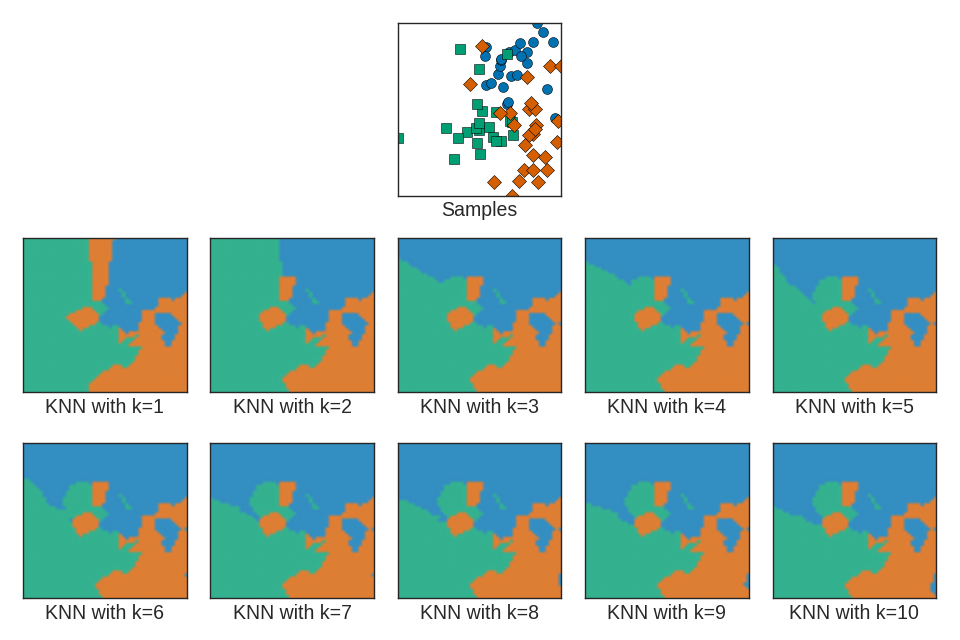

In [12]:
X_train = X2[::2]
Y_train = y2[::2].astype(int)
X_test = X2[1::2]
Y_test = y2[1::2].astype(int)

plt.figure(1, figsize=(12,8))
plt.subplot(3, 5, 3)
plot_2d(X_train, Y_train)
plt.xlabel('Samples')
ax = plt.gca()
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks([])

for n_neighbors in range(1, 11):
    knn = KNNClassifier(n_neighbors, weight)
    knn.fit(X_train, Y_train)
    plt.subplot(3, 5, 5 + n_neighbors)
    plt.xlabel('KNN with k=%d' % n_neighbors)

    def f(xx):
        return knn.predict(xx.reshape(1, -1))
    frontiere_new(f, X2, y2, w=None, step=50, alpha_choice=1,
                  colorbar=False, samples=False)
    plt.draw()  # update plot

plt.tight_layout()